In [70]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')



from scipy import stats
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

plt.rcParams['figure.figsize'] = (8,4)

[nltk_data] Downloading package punkt to /home/ken/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ken/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression

def select_kbest(X, y, k):
    f_selector = SelectKBest(f_regression, k)
    f_selector.fit(X, y)
    feature_mask = f_selector.get_support()

    f_feature = X.iloc[:,feature_mask].columns.tolist()
    return f_feature

def rfe(X,y,k):
    lm = LinearRegression()
    rfe = RFE(lm,k)
    rfe.fit(X, y)
    feature_mask_rfe = rfe.support_
    rfe_feature = X.iloc[:,feature_mask_rfe].columns.tolist()
    return rfe_feature

def scale_data(train,validate,test):
    '''Accepts train, validate, test data frames and applies min-max scaler
    return: train, validate, test scaled pandas dataframe'''
    
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train)
    
    train_scaled = scaler.transform(train)
    validate_scaled = scaler.transform(validate)
    test_scaled = scaler.transform(test)
    
    train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
    validate_scaled = pd.DataFrame(validate_scaled, columns=train.columns)
    test_scaled = pd.DataFrame(test_scaled, columns=train.columns)
    
    return train_scaled, validate_scaled, test_scaled

In [72]:
df = pd.read_csv('train.csv')
df.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ClaimNumber                54000 non-null  object 
 1   DateTimeOfAccident         54000 non-null  object 
 2   DateReported               54000 non-null  object 
 3   Age                        54000 non-null  int64  
 4   Gender                     54000 non-null  object 
 5   MaritalStatus              53971 non-null  object 
 6   DependentChildren          54000 non-null  int64  
 7   DependentsOther            54000 non-null  int64  
 8   WeeklyWages                54000 non-null  float64
 9   PartTimeFullTime           54000 non-null  object 
 10  HoursWorkedPerWeek         54000 non-null  float64
 11  DaysWorkedPerWeek          54000 non-null  int64  
 12  ClaimDescription           54000 non-null  object 
 13  InitialIncurredCalimsCost  54000 non-null  int

In [74]:
df.describe()

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,UltimateIncurredClaimCost
count,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,5.400000e+04,5.400000e+04
mean,33.842370,0.119185,0.009944,416.364807,37.735084,4.905759,7.841146e+03,1.100337e+04
std,12.122165,0.517780,0.109348,248.638669,12.568704,0.552129,2.058408e+04,3.339099e+04
min,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,1.218868e+02
25%,23.000000,0.000000,0.000000,200.000000,38.000000,5.000000,7.000000e+02,9.263384e+02
50%,32.000000,0.000000,0.000000,392.200000,38.000000,5.000000,2.000000e+03,3.371242e+03
75%,43.000000,0.000000,0.000000,500.000000,40.000000,5.000000,9.500000e+03,8.197249e+03
max,81.000000,9.000000,5.000000,7497.000000,640.000000,7.000000,2.000000e+06,4.027136e+06


In [75]:
train = pd.read_csv('train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ClaimNumber                54000 non-null  object 
 1   DateTimeOfAccident         54000 non-null  object 
 2   DateReported               54000 non-null  object 
 3   Age                        54000 non-null  int64  
 4   Gender                     54000 non-null  object 
 5   MaritalStatus              53971 non-null  object 
 6   DependentChildren          54000 non-null  int64  
 7   DependentsOther            54000 non-null  int64  
 8   WeeklyWages                54000 non-null  float64
 9   PartTimeFullTime           54000 non-null  object 
 10  HoursWorkedPerWeek         54000 non-null  float64
 11  DaysWorkedPerWeek          54000 non-null  int64  
 12  ClaimDescription           54000 non-null  object 
 13  InitialIncurredCalimsCost  54000 non-null  int

In [76]:
#Entire Dataset
#df_all = pd.concat([train.assign(role="train"), test.assign(role="test")])
df_all = train

In [77]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ClaimNumber                54000 non-null  object 
 1   DateTimeOfAccident         54000 non-null  object 
 2   DateReported               54000 non-null  object 
 3   Age                        54000 non-null  int64  
 4   Gender                     54000 non-null  object 
 5   MaritalStatus              53971 non-null  object 
 6   DependentChildren          54000 non-null  int64  
 7   DependentsOther            54000 non-null  int64  
 8   WeeklyWages                54000 non-null  float64
 9   PartTimeFullTime           54000 non-null  object 
 10  HoursWorkedPerWeek         54000 non-null  float64
 11  DaysWorkedPerWeek          54000 non-null  int64  
 12  ClaimDescription           54000 non-null  object 
 13  InitialIncurredCalimsCost  54000 non-null  int

In [78]:
df_all.isnull().sum()/len(df_all)*100

ClaimNumber                  0.000000
DateTimeOfAccident           0.000000
DateReported                 0.000000
Age                          0.000000
Gender                       0.000000
MaritalStatus                0.053704
DependentChildren            0.000000
DependentsOther              0.000000
WeeklyWages                  0.000000
PartTimeFullTime             0.000000
HoursWorkedPerWeek           0.000000
DaysWorkedPerWeek            0.000000
ClaimDescription             0.000000
InitialIncurredCalimsCost    0.000000
UltimateIncurredClaimCost    0.000000
dtype: float64

In [79]:
df_all.groupby(df_all['MaritalStatus'])['UltimateIncurredClaimCost'].agg(['mean','median','count'])

,mean,median,count
MaritalStatus,,,
M,12024.933597,4166.460054,22516
S,9105.578095,2322.799731,26161
U,16067.822199,5851.980317,5294


In [80]:
df_all[df_all['MaritalStatus'].isnull()]['UltimateIncurredClaimCost'].mean()

5325.896063958621

In [81]:
#Replacing nan with S
df_all['MaritalStatus'] = df_all['MaritalStatus'].fillna('S')

In [82]:
#Each Type Of Claim and its freq
df_all['ClaimDescription'].value_counts()

SLIPPED ON ROLLER TENDONITIS RIGHT SHOULDER                      289
SORTING ALUMINIUM BARS STRAIN SHOULDER NECK                      278
SLIPPED USING LATHE IN EYE CORNEA                                258
REDBACK SPIDER BITE RIGHT FOOT RIGHT FRACTURE                    256
LIFTING TYRES LOWER BACK STRAIN                                  255
                                                                ... 
STRUCK SLICING MACHINE LACERATION INDEX FINGER                     1
STRUCK PIECE METAL BURN RIGHT HAND                                 1
SLIPPED ON FLOOR AND STRUCK HEAD STRAINED NECK                     1
TURNING PALLET PALLET JACK LACERATED RIGHT RING FINGER             1
CUT WITH BREAD KNIFE LACERATION LEFT INDEX AND MIDDLE FINGERS      1
Name: ClaimDescription, Length: 28114, dtype: int64

In [84]:
# Claim Cost varies wrt claim descr. 
#df_all[df_all.role == 'train'].groupby(['ClaimDescription'])['UltimateIncurredClaimCost'].median().sort_values(ascending=False)
df_all.groupby(['ClaimDescription'])['UltimateIncurredClaimCost'].median().sort_values(ascending=False)

ClaimDescription
SLIPPED ON WET FLOOR FRACTURED BASE OF HAND                   4.027136e+06
WHILST MASSAGING FELT PAIN SOFT TISSUE INJURY LEFT HAND       8.657706e+05
TABLE TIPPED OVER SOFT TISSUE INJURY RIGHT HAND               8.237063e+05
HANDLING BROCOLLI PAIN AND SWELLING LEFT KNEE SOFT TISSUE     5.257133e+05
STAPLED FINGER WITH KNIFE STRESS TRAUMA                       5.164342e+05
                                                                  ...     
METAL FOREIGN BODY LEFT EYE                                   1.423778e+02
HIT AGAINST WELDER MACHINE BRUISED ABRASION RIGHT EYE         1.412889e+02
PARTICLE FELL INTO EYE FOREIGN BODY IN LEFT SHOULDER          1.343203e+02
PARTICLE IN EYE WHILE GRINDING FOREIGN BODY RIGHT EYE AREA    1.314570e+02
GLASS INTO EYE FOREIGN BODY LEFT EYE                          1.245797e+02
Name: UltimateIncurredClaimCost, Length: 28114, dtype: float64

In [85]:
# Number Of words in each claim description
df_all['word_count'] = df_all['ClaimDescription'].apply(lambda x:len(x))

In [86]:
#  word count statistics in each claim description
df_all['word_count'].describe()

count    54000.000000
mean        43.453704
std         10.217058
min          3.000000
25%         37.000000
50%         43.000000
75%         50.000000
max         94.000000
Name: word_count, dtype: float64

In [87]:
stops = stopwords.words('english')

def text_clean(claim):
    
    
    #Converting to Lower Case
    claim = claim.lower()
    
    #Getting List Of Words
    claim = claim.split()
    
    #Removing Stop Words(Words which do not add any information like =is,are,I etc)
    claim = [word for word in claim if word not in stops]
    
    #Stemming the word(words like playing ,played are replaced with play)
    porter_stemmer = PorterStemmer()
    claim = [porter_stemmer.stem(word) for word in claim]
    
    
    return claim


In [88]:
df_all['ClaimDescriptionClean'] = df_all['ClaimDescription'].apply(lambda x:' '.join(text_clean(x)))

In [89]:
corpus = df_all['ClaimDescriptionClean']
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

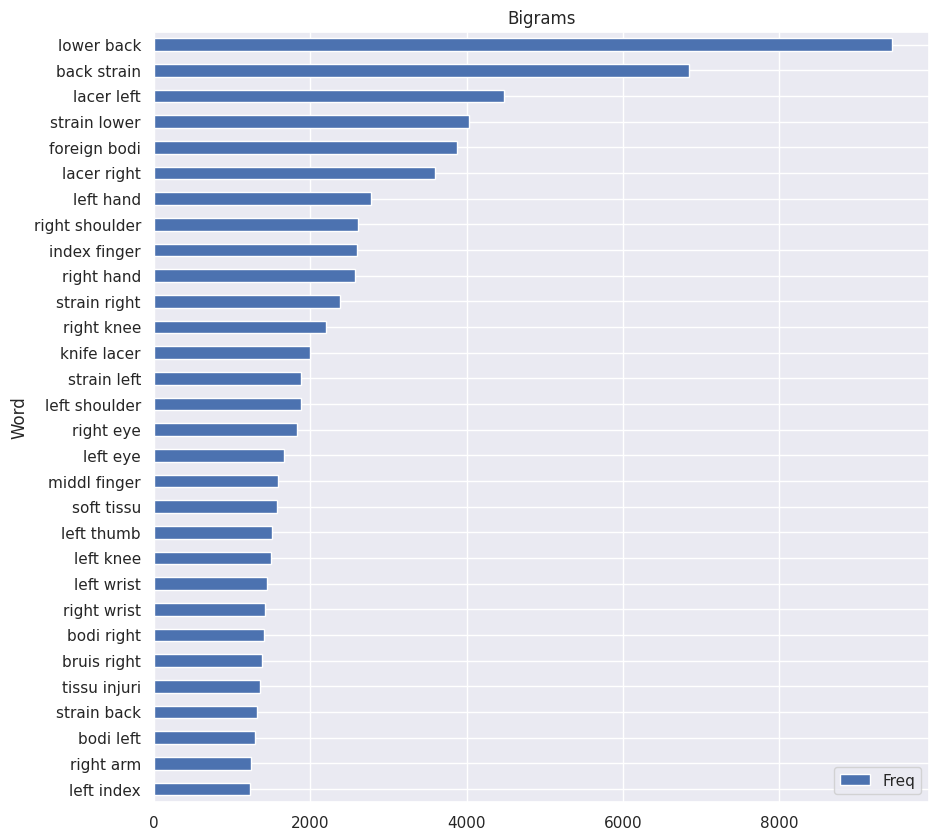

In [90]:
#Most common pairs of words that occur together in Claim Description

plt.figsize=((25,30))
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns = ["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:30,:].sort_values(by="Freq").plot(kind="barh",figsize=(10,10))
plt.title('Bigrams')
                  
plt.show()

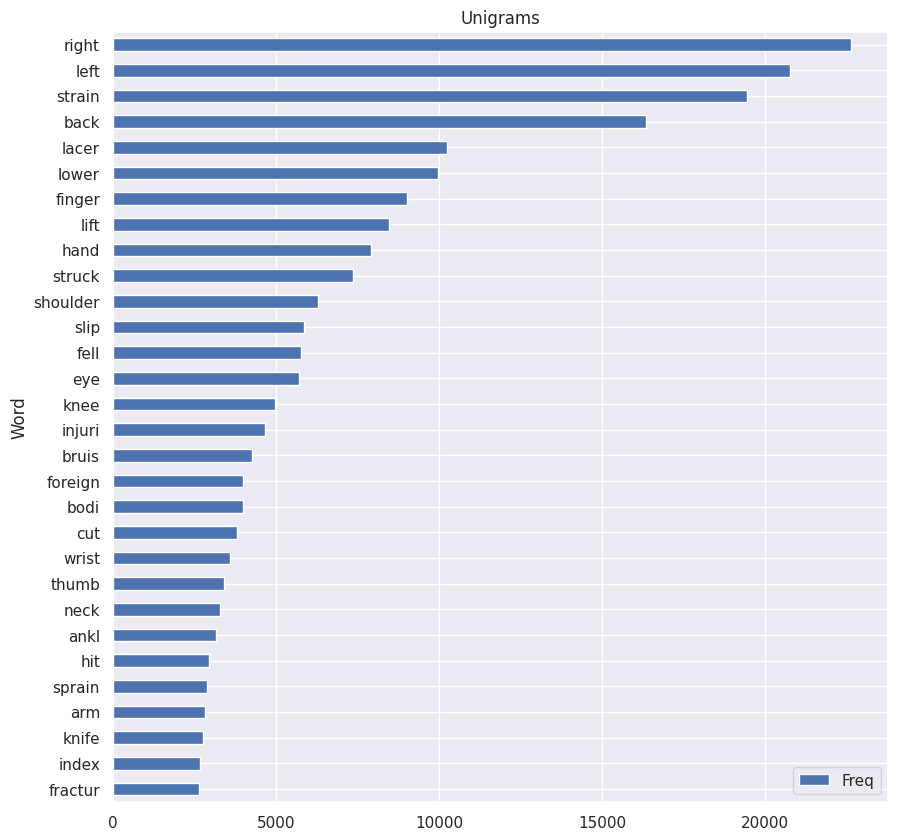

In [91]:
# single words that frequently occur in claim descr.

plt.figsize = ((25,30))
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 1))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns = ["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:30,:].sort_values(by="Freq").plot(kind="barh",figsize=(10,10))
plt.title('Unigrams')
                  
plt.show()

In [92]:
#Creating new features based on claim descr

cd_features = ['foreign bodi','lacer','tissu injuri','strain','lower back',
               'knee','wrist','eye','hand','fractur','sprain','knife','slip',
               'finger','tendon','synov','conjunct']

for feature in cd_features:
    df_all['CD_'+'_'.join(feature.split())] = df_all['ClaimDescriptionClean'].apply(lambda x:1 if feature in x else 0)
    
#Creating Features based on Claim description col.   
cd_features = ['CD_'+'_'.join(feature.split()) for feature in cd_features]


In [93]:
df_all.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,...,CD_eye,CD_hand,CD_fractur,CD_sprain,CD_knife,CD_slip,CD_finger,CD_tendon,CD_synov,CD_conjunct
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,...,0,0,0,0,0,0,0,0,0,0
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,...,0,0,1,0,0,0,0,0,0,0
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,...,0,0,0,0,0,0,0,0,0,0
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,...,0,0,0,0,0,0,0,0,0,0
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,...,0,0,0,0,0,0,0,0,0,0


In [94]:
df_all[['DateTimeOfAccident', 'DateReported']].tail()

,DateTimeOfAccident,DateReported
53995,2004-08-21T18:00:00Z,2004-09-08T00:00:00Z
53996,2002-04-28T09:00:00Z,2002-09-03T00:00:00Z
53997,1992-02-28T09:00:00Z,1992-03-18T00:00:00Z
53998,1995-01-10T07:00:00Z,1995-01-31T00:00:00Z
53999,1990-10-24T14:00:00Z,1990-11-03T00:00:00Z


In [95]:
df_all['DateTimeOfAccident']=pd.to_datetime(df_all['DateTimeOfAccident'])
df_all['DateReported']=pd.to_datetime(df_all['DateReported'])

df_all['Rep_Acc_Diff']=df_all['DateReported']-df_all['DateTimeOfAccident']
df_all['Rep_Acc_Diff']=df_all['Rep_Acc_Diff'].apply(lambda x:str(x)[:2])
df_all['Rep_Acc_Diff']=df_all['Rep_Acc_Diff'].astype('int')

df_all['Accident_Month']=df_all['DateTimeOfAccident'].dt.month
df_all['Accident_Year']=df_all['DateTimeOfAccident'].dt.year
df_all['Accident_Day']=df_all['DateTimeOfAccident'].dt.day
df_all['Accident_Hour']=df_all['DateTimeOfAccident'].dt.hour
df_all['Accident_Time']=df_all['DateTimeOfAccident'].dt.time



df_all['Reported_Month']=df_all['DateReported'].dt.month
df_all['Reported_Year']=df_all['DateReported'].dt.year
df_all['Reported_Day']=df_all['DateReported'].dt.day


In [96]:
#train = df_all[df_all.role=='train']
train = df_all

In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   ClaimNumber                54000 non-null  object             
 1   DateTimeOfAccident         54000 non-null  datetime64[ns, UTC]
 2   DateReported               54000 non-null  datetime64[ns, UTC]
 3   Age                        54000 non-null  int64              
 4   Gender                     54000 non-null  object             
 5   MaritalStatus              54000 non-null  object             
 6   DependentChildren          54000 non-null  int64              
 7   DependentsOther            54000 non-null  int64              
 8   WeeklyWages                54000 non-null  float64            
 9   PartTimeFullTime           54000 non-null  object             
 10  HoursWorkedPerWeek         54000 non-null  float64            
 11  Da

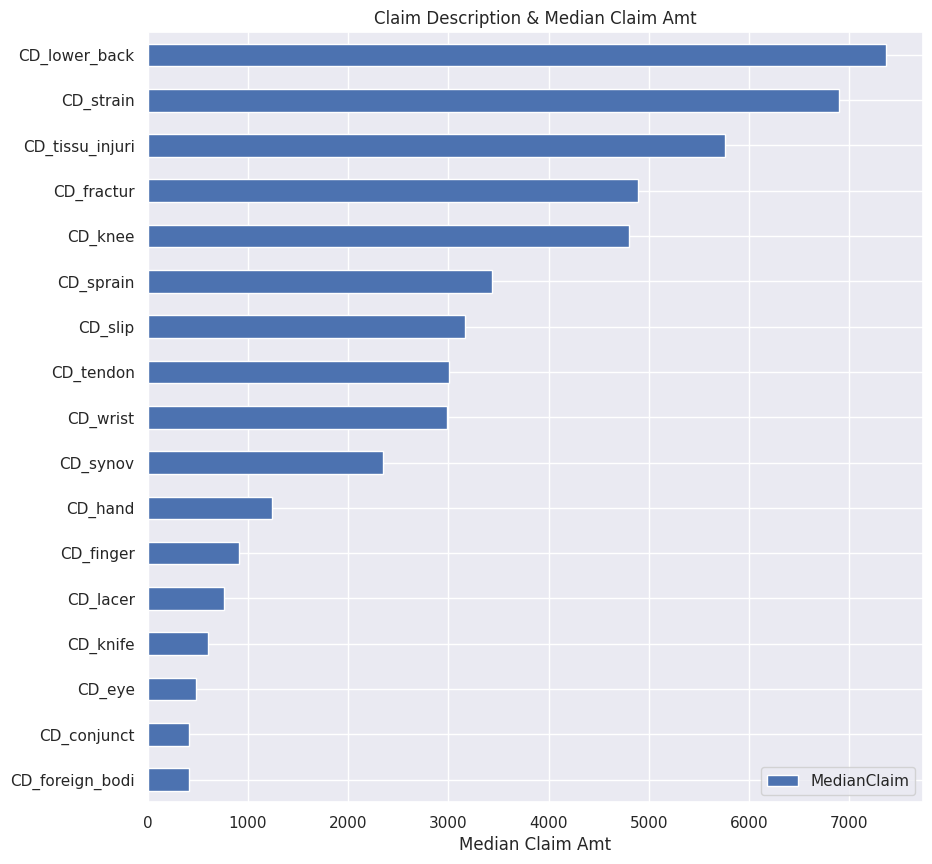

In [98]:
cd_feat_claim_median = pd.DataFrame({feature:train[train[feature] == 1]['UltimateIncurredClaimCost'].median() for feature in cd_features},index=['MedianClaim']
).T.sort_values(by = 'MedianClaim')

cd_feat_claim_median.plot(kind ='barh',figsize = (10,10))

plt.xlabel('Median Claim Amt')
plt.title('Claim Description & Median Claim Amt')
plt.show()


In [99]:
date_cols = [col for col in train.columns if col.split('_')[-1] in ['Month','Year','Day','Time']]

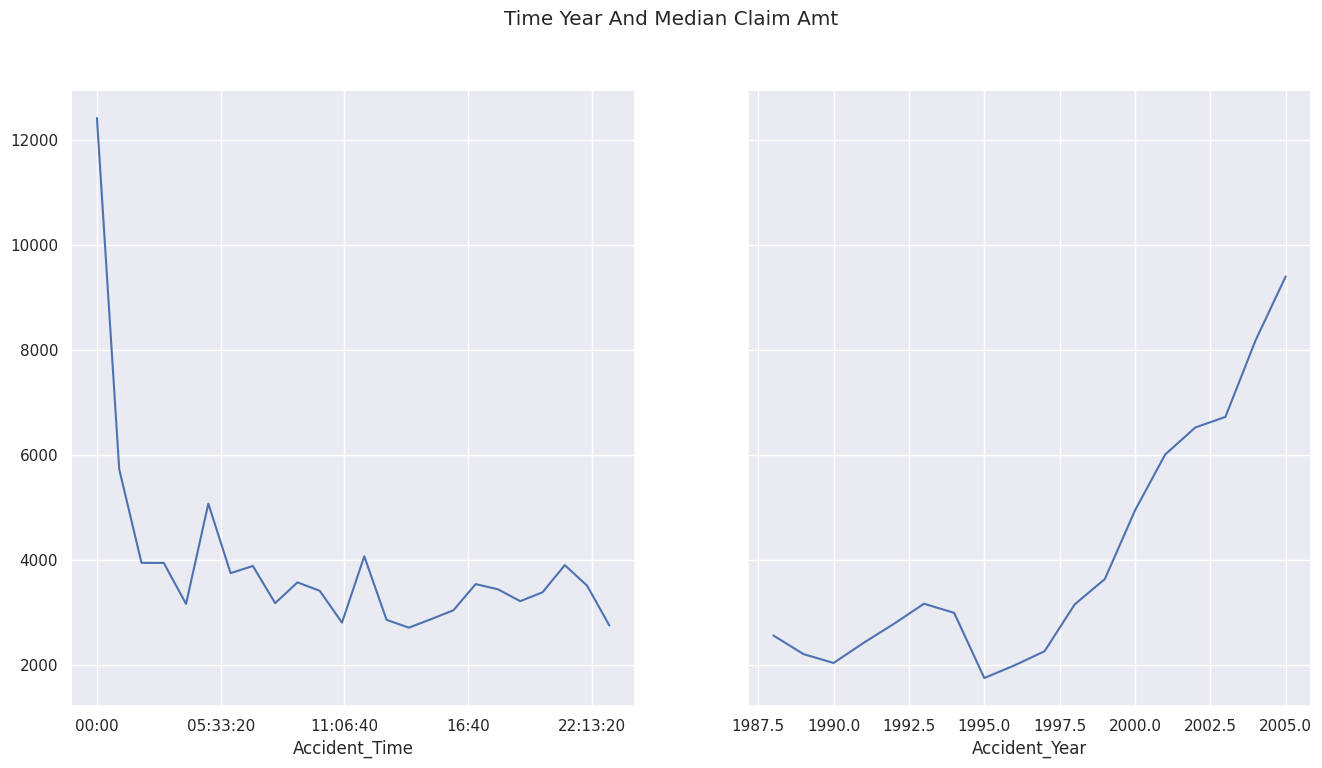

In [100]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize = (16,8))
fig.suptitle('Time Year And Median Claim Amt')
plt.ylabel('Median Claim Amt')

train.groupby(train['Accident_Time'])['UltimateIncurredClaimCost'].median().plot(ax = ax[0])
train.groupby(train['Accident_Year'])['UltimateIncurredClaimCost'].median().plot(ax = ax[1])

plt.show()


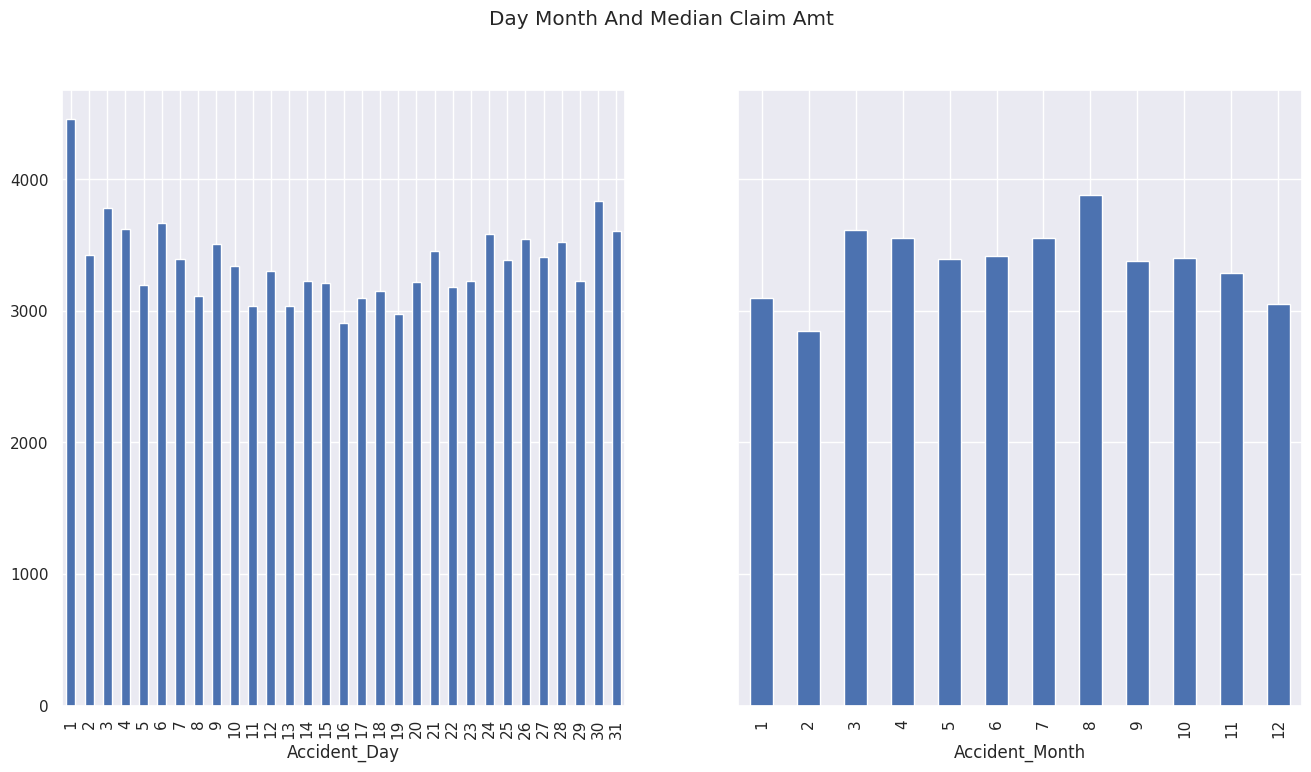

In [101]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize = (16,8))
fig.suptitle('Day Month And Median Claim Amt')
plt.ylabel('Median Claim Amt')

train.groupby(train['Accident_Day'])['UltimateIncurredClaimCost'].median().plot(kind='bar',ax=ax[0])
train.groupby(train['Accident_Month'])['UltimateIncurredClaimCost'].median().plot(kind='bar',ax=ax[1])

plt.show()


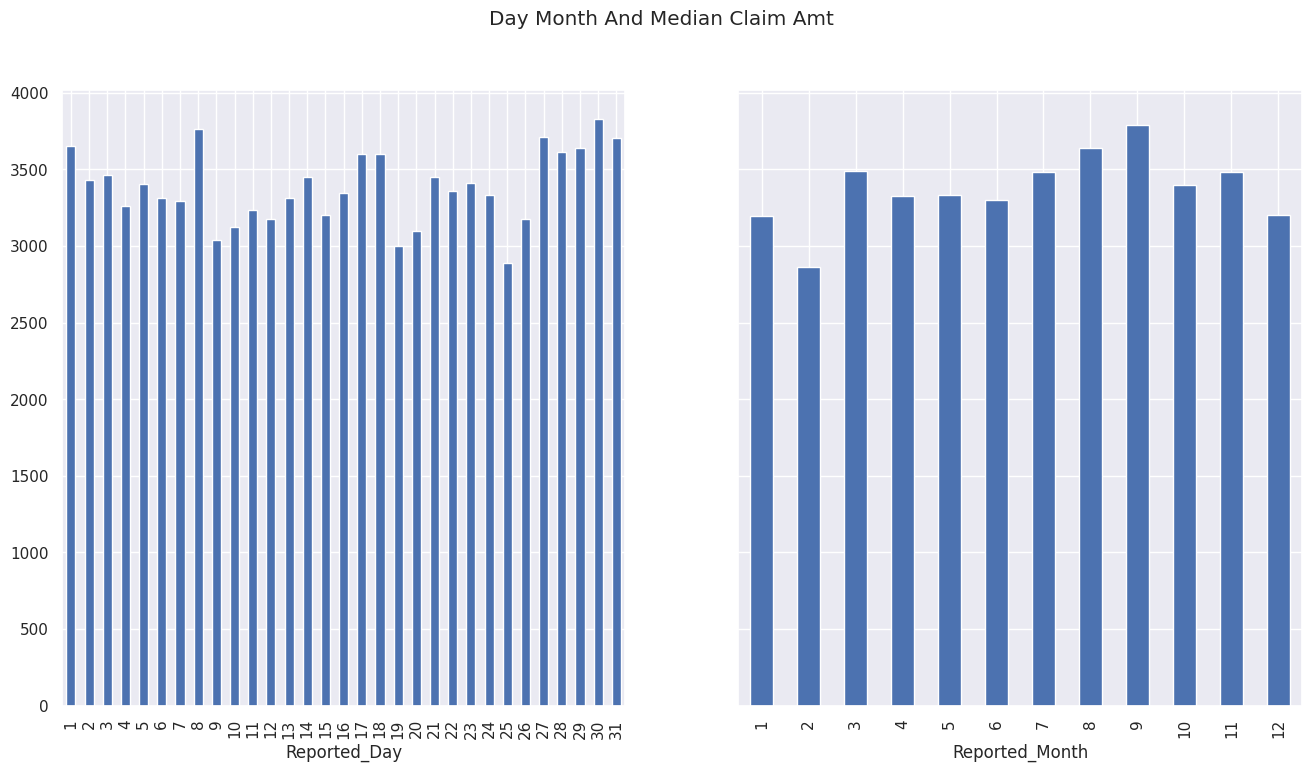

In [102]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,8))
fig.suptitle('Day Month And Median Claim Amt')
plt.ylabel('Median Claim Amt')

train.groupby(train['Reported_Day'])['UltimateIncurredClaimCost'].median().plot(kind='bar',ax=ax[0])
train.groupby(train['Reported_Month'])['UltimateIncurredClaimCost'].median().plot(kind='bar',ax=ax[1])

plt.show()



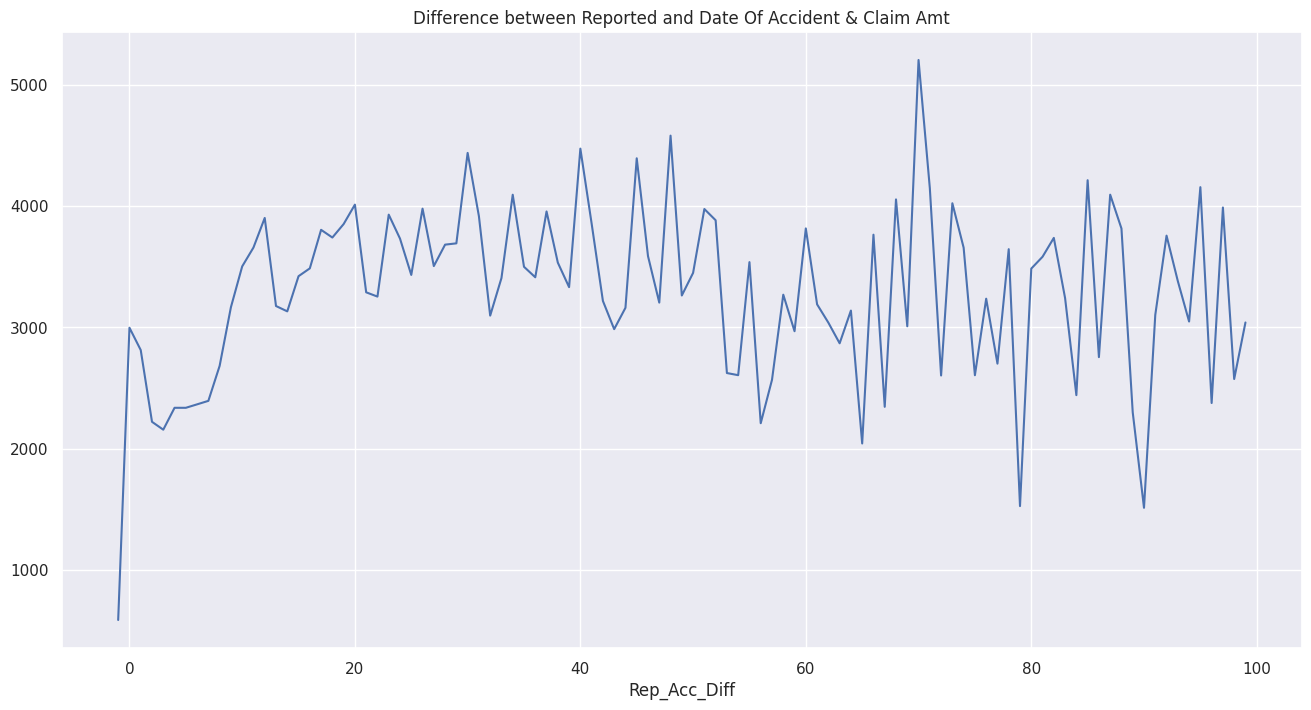

In [103]:
plt.figure(figsize=(16,8))
train.groupby(train['Rep_Acc_Diff'])['UltimateIncurredClaimCost'].median().plot()
plt.title('Difference between Reported and Date Of Accident & Claim Amt')
plt.show()

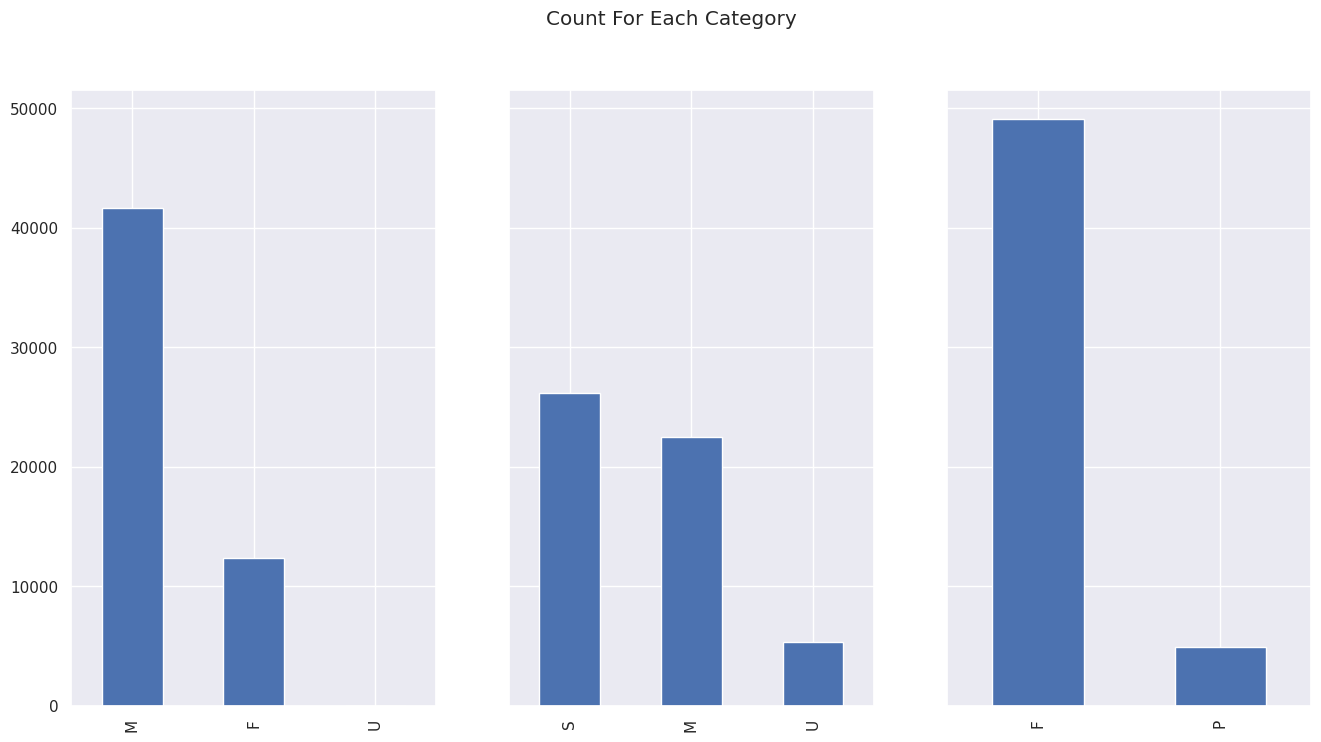

In [104]:
categoric = ['Gender','MaritalStatus','PartTimeFullTime']
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16,8))
fig.suptitle('Count For Each Category')

for i,col in enumerate(categoric):
    train[col].value_counts().plot(kind='bar',ax=ax[i])



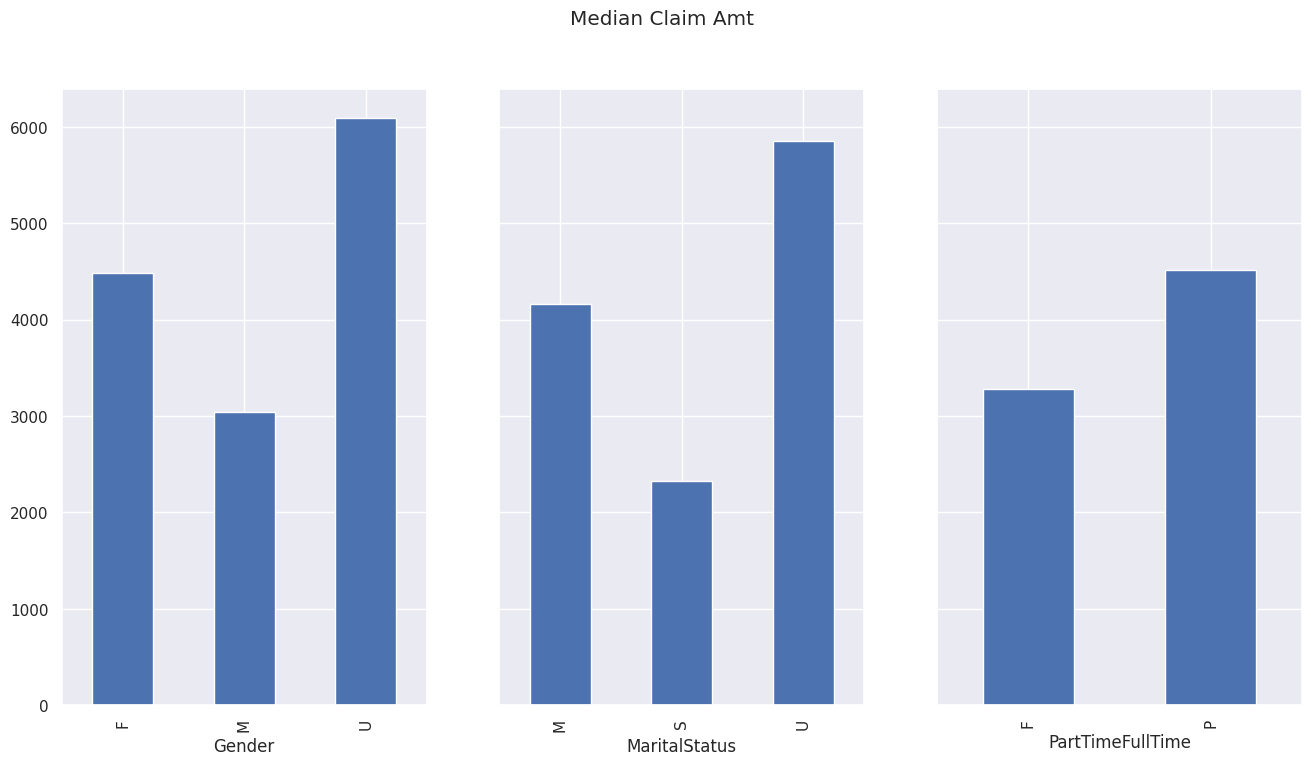

In [105]:
categoric=['Gender','MaritalStatus','PartTimeFullTime']
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16,8))
fig.suptitle('Median Claim Amt')

for i,col in enumerate(categoric):
    train.groupby(train[col])['UltimateIncurredClaimCost'].median().plot(kind='bar',ax=ax[i])



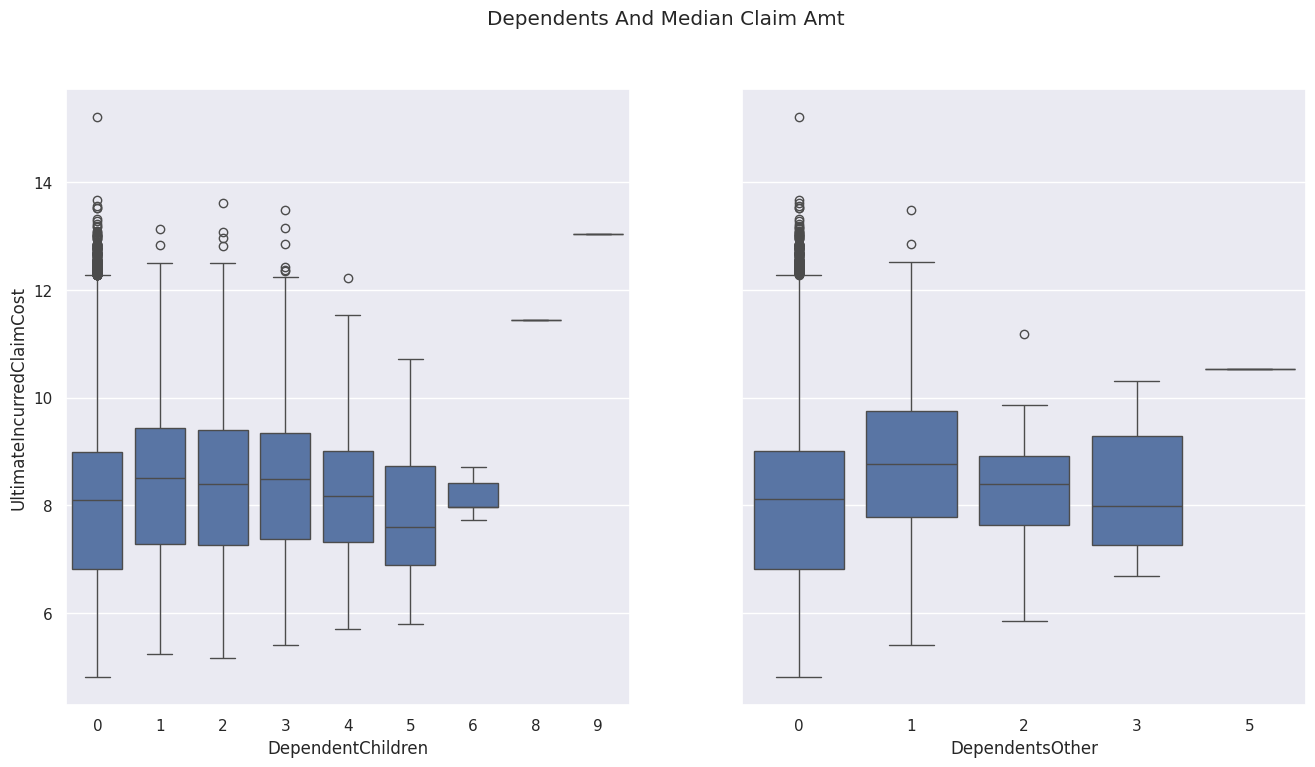

In [106]:
dep = ['DependentChildren','DependentsOther']
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,8))
fig.suptitle('Dependents And Median Claim Amt')

for i,col in enumerate(dep):
    sns.boxplot(x=train[col],y=np.log(train['UltimateIncurredClaimCost']),ax=ax[i])

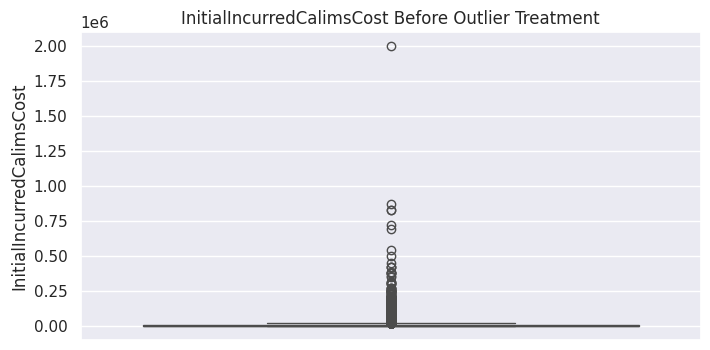

In [107]:
#Outlier Analysis of InitialIncurredCalimsCost

sns.boxplot(df_all['InitialIncurredCalimsCost'])
plt.title('InitialIncurredCalimsCost Before Outlier Treatment')
plt.show()

In [108]:
#Capping Outliers
df_all.loc[df_all['InitialIncurredCalimsCost'] >= df_all['InitialIncurredCalimsCost'].quantile(.95),
           'InitialIncurredCalimsCost'] = df_all['InitialIncurredCalimsCost'].quantile(.95)

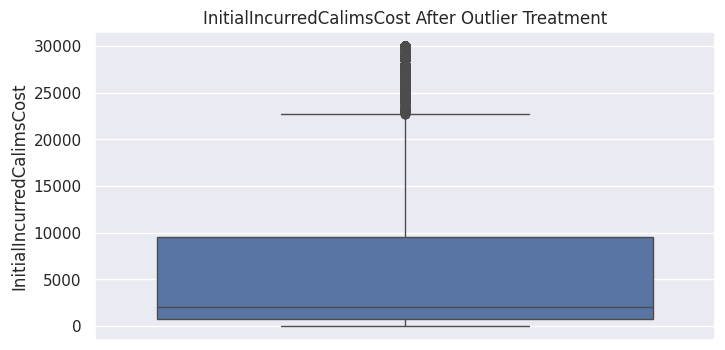

In [109]:
sns.boxplot(df_all['InitialIncurredCalimsCost'])
plt.title('InitialIncurredCalimsCost After Outlier Treatment')
plt.show()

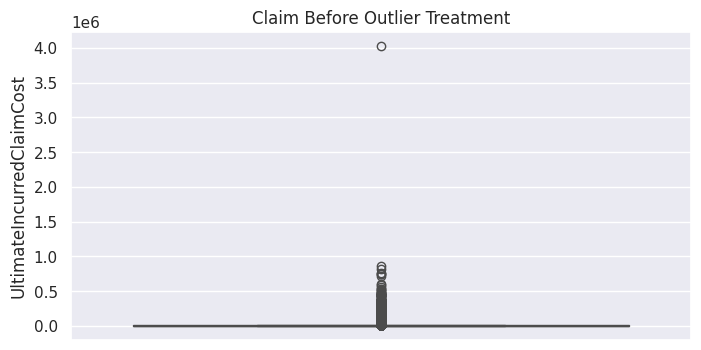

In [110]:
sns.boxplot(df_all['UltimateIncurredClaimCost'])
plt.title('Claim Before Outlier Treatment')
plt.show()

In [111]:
# Outlier Treatment
train.loc[train['UltimateIncurredClaimCost']>=train['UltimateIncurredClaimCost'].quantile(.95),
          'UltimateIncurredClaimCost']=train['UltimateIncurredClaimCost'].quantile(.95)

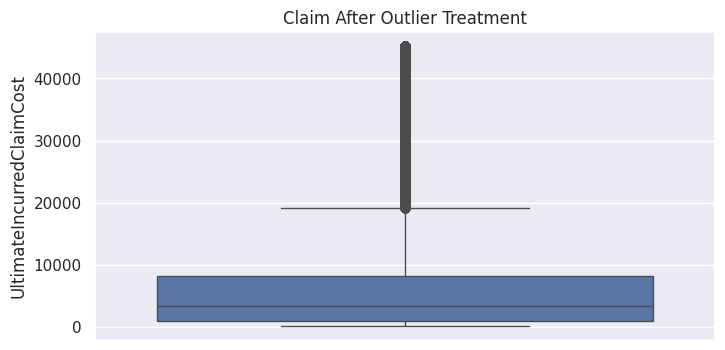

In [112]:
#After Outlier Treatment
sns.boxplot(train['UltimateIncurredClaimCost'])
plt.title('Claim After Outlier Treatment')
plt.show()

In [113]:
#train=df_all[df_all.role=='train']
#test=df_all[df_all.role=='test']
train=df_all

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   ClaimNumber                54000 non-null  object             
 1   DateTimeOfAccident         54000 non-null  datetime64[ns, UTC]
 2   DateReported               54000 non-null  datetime64[ns, UTC]
 3   Age                        54000 non-null  int64              
 4   Gender                     54000 non-null  object             
 5   MaritalStatus              54000 non-null  object             
 6   DependentChildren          54000 non-null  int64              
 7   DependentsOther            54000 non-null  int64              
 8   WeeklyWages                54000 non-null  float64            
 9   PartTimeFullTime           54000 non-null  object             
 10  HoursWorkedPerWeek         54000 non-null  float64            
 11  Da

In [117]:
train_id = train.ClaimNumber
#test_id = test.ClaimNumber

train.drop(['ClaimNumber','DateTimeOfAccident', 'DateReported','ClaimDescription', 'word_count',
       'ClaimDescriptionClean','Accident_Time'],axis=1,inplace=True)

#test.drop(['ClaimNumber','DateTimeOfAccident', 'DateReported','ClaimDescription','role', 'word_count',
 #      'ClaimDescriptionClean','Accident_Time'],axis=1,inplace=True)

In [118]:
train = pd.get_dummies(train)
#test = pd.get_dummies(test) 

In [119]:
train.drop(['Gender_U','MaritalStatus_U','PartTimeFullTime_P'],axis=1,inplace=True)
#test.drop(['MaritalStatus_U','PartTimeFullTime_P'],axis=1,inplace=True)

In [120]:
# Train test Split of train data
from sklearn.model_selection import  train_test_split

In [121]:
X = train.drop(['UltimateIncurredClaimCost'],axis=1)
Y = train['UltimateIncurredClaimCost']

In [122]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        54000 non-null  int64  
 1   DependentChildren          54000 non-null  int64  
 2   DependentsOther            54000 non-null  int64  
 3   WeeklyWages                54000 non-null  float64
 4   HoursWorkedPerWeek         54000 non-null  float64
 5   DaysWorkedPerWeek          54000 non-null  int64  
 6   InitialIncurredCalimsCost  54000 non-null  int64  
 7   CD_foreign_bodi            54000 non-null  int64  
 8   CD_lacer                   54000 non-null  int64  
 9   CD_tissu_injuri            54000 non-null  int64  
 10  CD_strain                  54000 non-null  int64  
 11  CD_lower_back              54000 non-null  int64  
 12  CD_knee                    54000 non-null  int64  
 13  CD_wrist                   54000 non-null  int

# Scale

In [123]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,train_size=0.7)

In [124]:
X_train.head()

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,CD_foreign_bodi,CD_lacer,CD_tissu_injuri,...,Accident_Day,Accident_Hour,Reported_Month,Reported_Year,Reported_Day,Gender_F,Gender_M,MaritalStatus_M,MaritalStatus_S,PartTimeFullTime_F
18606,32,0,0,200.00,38.0,5,15000,0,0,0,...,6,12,4,2002,11,0,1,0,1,1
42702,21,0,0,417.20,37.5,5,3500,0,0,1,...,5,1,5,1992,27,1,0,0,1,1
30125,44,0,0,482.61,38.0,5,3000,0,0,0,...,6,13,3,1997,16,0,1,1,0,1
36026,54,0,0,417.80,38.0,5,10000,0,0,0,...,17,12,3,1998,31,1,0,0,1,1
17583,25,0,0,300.00,38.0,5,25200,0,0,0,...,8,12,3,1994,23,0,1,0,1,1


In [125]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16200 entries, 52213 to 17117
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        16200 non-null  int64  
 1   DependentChildren          16200 non-null  int64  
 2   DependentsOther            16200 non-null  int64  
 3   WeeklyWages                16200 non-null  float64
 4   HoursWorkedPerWeek         16200 non-null  float64
 5   DaysWorkedPerWeek          16200 non-null  int64  
 6   InitialIncurredCalimsCost  16200 non-null  int64  
 7   CD_foreign_bodi            16200 non-null  int64  
 8   CD_lacer                   16200 non-null  int64  
 9   CD_tissu_injuri            16200 non-null  int64  
 10  CD_strain                  16200 non-null  int64  
 11  CD_lower_back              16200 non-null  int64  
 12  CD_knee                    16200 non-null  int64  
 13  CD_wrist                   16200 non-null 

In [126]:
import xgboost

In [127]:
#Training on default params
model = xgboost.XGBRegressor() 
model.fit(X_train,y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [128]:
model.predict(X_test)

array([ 3317.4966 ,  1052.5665 ,   742.11053, ...,   631.9725 ,
        8208.172  , 15144.599  ], dtype=float32)

In [129]:
from sklearn.metrics import mean_absolute_error

In [130]:
mean_absolute_error(y_test,model.predict(X_test))

3443.3530135097285

In [131]:
parameters={'colsample_bytree':[0.4],
                 'gamma':[0],                 
                 'learning_rate':[0.07,0.09,0.1],
                 'max_depth':[2,3,4],
                 'n_estimators':[1000,2000,3000],                                                                   
                 'reg_alpha':[0.7,0.75,0.8],
                 'reg_lambda':[0.45,0.8,1],
                 'subsample':[0.6],
                 }

In [132]:
from sklearn.model_selection import RandomizedSearchCV

In [133]:
reg_clf=RandomizedSearchCV(estimator=model,param_distributions=parameters,cv=3,
                           n_jobs=-1,scoring='neg_mean_absolute_error',verbose=100)

In [134]:
mean_absolute_error(y_test,reg_clf.estimator.predict(X_test))

3443.3530135097285

In [137]:
train['UltimateIncurredClaimCost'].describe()

count    54000.000000
mean      7938.089109
std      11594.863761
min        121.886805
25%        926.338449
50%       3371.241730
75%       8197.248648
max      45224.184435
Name: UltimateIncurredClaimCost, dtype: float64